<a href="https://colab.research.google.com/github/Gladn/Colaboratory_new/blob/main/Hug1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import logging
import random
from tqdm import tqdm
from collections import defaultdict

import pandas as pd
import numpy as np

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import torch
from torch import nn, Tensor
from torchvision import models
from torchvision.transforms import Compose
from torchvision.transforms import functional as F

import warnings
warnings.filterwarnings('ignore')

HaGRID разделен на 18 классов жестов и один класс без жестов. Мы не используем много эпох из-за подвыборки набора данных, выбранного для этого руководства, и модель может быстро обучаться.

In [ ]:
class_names = ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one',
               'palm', 'peace', 'rock', 'stop', 'stop_inverted', 'three', 'two_up',
               'two_up_inverted', 'three2', 'peace_inverted', 'no_gesture']

num_classes = len(class_names)
random_seed = 42
batch_size = 64
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!wget https://sc.link/AO5l -O sample.zip

In [ ]:
!wget https://sc.link/EQ5g -O ann_subsample.zip

In [ ]:
!unzip ann_subsample.zip -d /content/annotation/

In [ ]:
!unzip /content/sample.zip -d /content/dataset/

In [ ]:
class GestureDataset(torch.utils.data.Dataset):

    def __init__(self, path, is_train=True, transform=None):

        self.path = path
        self.is_train = is_train
        self.transform = transform
        self.labels = {label: num for (label, num) in
                         zip(class_names, range(len(class_names)))}

        self.leading_hand = {'right': 0, 'left': 1}
        self.annotations = self.__read_annotations(self.path)

        users = self.annotations['user_id'].unique()
        users = sorted(users)
        random.Random(42).shuffle(users)

        train_users = users[:int(len(users) * 0.8)]
        test_users = users[int(len(users) * 0.8):]

        self.annotations = self.annotations.copy()
        if self.is_train:
            train_users_annotations = self.annotations['user_id'].isin(train_users)
            self.annotations = self.annotations[train_users_annotations]
        else:
            test_users_annotations = self.annotations['user_id'].isin(test_users)
            self.annotations = self.annotations[test_users_annotations]

    def __read_annotations(self, path):
        json_annotations = json.load(open(os.path.join(self.path, "ann_subsample.json")))
        json_annotations = [dict(ann, **{'name': f'{name}.jpg'}) for name, ann in
                            zip(json_annotations, json_annotations.values())]
        annotations = pd.DataFrame(json_annotations)

        labels = list(annotations['labels'])
        targets = []
        for label in labels:
            targets.append([item for item in label if item != 'no_gesture'][0])

        annotations['target'] = targets
        return annotations

    def __prepare_image_target(self, target, name, bboxes, labels, leading_hand):
        image_pth = os.path.join(self.path, target, name)
        image = Image.open(image_pth).convert('RGB')
        width, height = image.size

        choice = np.random.choice(['gesture', 'no_gesture'], p=[0.7, 0.3])
        bboxes_by_class = {}
        for i, bbox in enumerate(bboxes):
            x1, y1, w, h = bbox
            bbox_abs = [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]

            if labels[i] == 'no_gesture':
                bboxes_by_class['no_gesture'] = (bbox_abs, labels[i])
            else:
                bboxes_by_class['gesture'] = (bbox_abs, labels[i])

        if choice not in bboxes_by_class:
            choice = list(bboxes_by_class.keys())[0]

        box_scale = 1.0
        image_cropped, bbox_orig = self.get_crop_from_bbox(image,
                                                           bboxes_by_class[choice][0],
                                                           box_scale=box_scale)
        image_resized = ImageOps.pad(image_cropped, tuple([224, 224]), color=(0, 0, 0))

        gesture = bboxes_by_class[choice][1]
        leading_hand_class = leading_hand

        if gesture == 'no_gesture':
            leading_hand_class = 'right' if leading_hand == 'left' else 'left'

        return image_resized, gesture, leading_hand_class

    @staticmethod
    def get_crop_from_bbox(image, bbox, box_scale=1.):
        int_bbox = np.array(bbox).round().astype(np.int32)
        x1 = int_bbox[0]
        y1 = int_bbox[1]
        x2 = int_bbox[2]
        y2 = int_bbox[3]
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

        w = h = max(x2 - x1, y2 - y1)
        x1 = max(0, cx - box_scale * w // 2)
        y1 = max(0, cy - box_scale * h // 2)
        x2 = cx + box_scale * w // 2
        y2 = cy + box_scale * h // 2
        x1, y1, x2, y2 = list(map(int, (x1, y1, x2, y2)))

        crop_image = image.crop((x1, y1, x2, y2))
        bbox_orig = np.array([x1, y1, x2, y2]).reshape(2, 2)

        return crop_image, bbox_orig

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, index):
        row = self.annotations.iloc[[index]].to_dict('records')[0]
        image_resized, gesture, leading_hand = self.__prepare_image_target(
            row['target'],
            row['name'],
            row['bboxes'],
            row['labels'],
            row['leading_hand']
        )

        label = {'gesture': self.labels[gesture],
                 'leading_hand': self.leading_hand[leading_hand]}

        if self.transform is not None:
            image_resized = self.transform(image_resized)

        return image_resized, label

Кроме того, мы реализуем собственный класс ToTensor для функции get_transform():

In [ ]:
class ToTensor(nn.Module):
    @staticmethod
    def forward(image):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image

def get_transform():
    transforms = [ToTensor()]
    return Compose(transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

Мы указываем два разных набора данных: один для обучения модели (обучающий набор), а другой — для ее проверки (тестовый набор). Две команды отличаются одним параметром is_train, который разбивает весь набор данных на 2 части пользователями с хешем user_id. Вы можете разделить обучающий набор на обучающий и проверочный наборы, если у вас есть больше данных.

In [ ]:
train_data = GestureDataset(path='dataset/', is_train=True, transform=get_transform())
test_data = GestureDataset(path='dataset/', is_train=False, transform=get_transform())

In [ ]:
image, label = train_data[10]
print('image shape: ', image.shape)
print('label:', label)

image shape:  torch.Size([3, 224, 224])
label: {'gesture': 0, 'leading_hand': 1}


In [ ]:
short_class_names = []

for name in class_names:
    if name == 'stop_inverted':
        short_class_names.append('stop inv.')
    elif name == 'peace_inverted':
        short_class_names.append('peace inv.')
    elif name == 'two_up':
        short_class_names.append('two up')
    elif name == 'two_up_inverted':
        short_class_names.append('two up inv.')
    elif name == 'no_gesture':
        short_class_names.append('no gesture')
    else:
        short_class_names.append(name)

Давайте попробуем визуализировать несколько изображений, чтобы убедиться, что данные обрабатываются правильно:

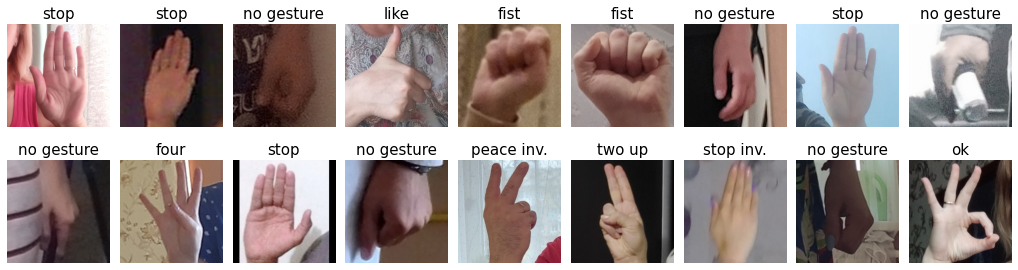

In [ ]:
i = 0
plt.rcParams['figure.figsize'] = (18, 5)
plt.subplots_adjust(wspace=0, hspace=0)

for k in range(18):
    s = random.randint(0, len(test_data) - 1)
    sample = test_data[s]
    image = sample[0]
    label = sample[1]
    image = np.swapaxes(image, 0, 1)
    image = np.swapaxes(image, 1, 2)

    plt.subplot(2, 9, i + 1)
    plt.title(f"{short_class_names[label['gesture']]}", fontsize=15)
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.imshow(image)
    plt.axis('off')
    i += 1

аконец, мы можем поместить наши изображения в DataLoader.

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               collate_fn=collate_fn, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              collate_fn=collate_fn, shuffle=True)

In [ ]:
num_epochs = 5
num_classes = 19
batch_size = 64
learning_rate = 0.001

In [ ]:
class ConvNet(nn.Module):
     def __init__(self):
         super(ConvNet, self).__init__()
         self.layer1 = nn.Sequential( nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
         self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
         self.drop_out = nn.Dropout()
         self.fc1 = nn.Linear(7 * 7 * 64, 1000)
         self.fc2 = nn.Linear(1000, 10)
     def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = out.reshape(out.size(0), -1)
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return out

In [ ]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 29.6 MB/s 


In [ ]:
from torchmetrics.functional import f1_score, confusion_matrix